In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
from statsmodels.tsa.ar_model import _ar_predict_out_of_sample
from sklearn.preprocessing import StandardScaler
from copy import *
from sklearn.decomposition import PCA
%matplotlib inline
sns.set(rc = {"figure.figsize" : (8, 6)})

In [87]:
data = pd.read_csv("scada_data.csv")

In [3]:
Group_2 = [
           'WEC: ava. windspeed', 'WEC: max. windspeed', 'WEC: ava. Rotation', 'WEC: max. Rotation','WEC: ava. Power', 'WEC: max. Power', 'WEC: min. Power', 
           'WEC: ava. reactive Power', 'WEC: max. reactive Power', 'WEC: min. reactive Power', 'WEC: ava. available P from wind', 'WEC: ava. available P technical reasons',
           'WEC: ava. Available P force majeure reasons', 'WEC: ava. Available P force external reasons','Rotor temp. 1', 'Rotor temp. 2', 'Stator temp. 1', 'Stator temp. 2'

]
Group_5 = [
           'Sys 1 inverter 1 cabinet temp.', 'Sys 1 inverter 2 cabinet temp.','Sys 1 inverter 3 cabinet temp.', 'Sys 1 inverter 4 cabinet temp.',
           'Sys 1 inverter 5 cabinet temp.', 'Sys 1 inverter 6 cabinet temp.','Sys 1 inverter 7 cabinet temp.', 'Sys 2 inverter 1 cabinet temp.',
           'Sys 2 inverter 2 cabinet temp.', 'Sys 2 inverter 3 cabinet temp.', 'Sys 2 inverter 4 cabinet temp.', 'Sys 2 inverter 5 cabinet temp.','Spinner temp.',
           'Front bearing temp.', 'Rear bearing temp.', 'Pitch cabinet blade A temp.', 'Pitch cabinet blade B temp.', 'Pitch cabinet blade C temp.', 
           'Nacelle ambient temp. 1', 'Nacelle ambient temp. 2', 'Nacelle temp.', 'Nacelle cabinet temp.', 'Main carrier temp.','Rectifier cabinet temp.', 
           'Yaw inverter cabinet temp.','Fan inverter cabinet temp.', 'Ambient temp.', 'Tower temp.','Control cabinet temp.', 'Transformer temp.','Inverter averages'

]

In [259]:
datagroup_2 = deepcopy(data[Group_2])
datagroup_5 = deepcopy(data[Group_5])

In [260]:
def pca_process(datagroup_2,datagroup_5):
    g2 = datagroup_2.loc[3000:]
    g5 = datagroup_5.loc[3000:]
    scaler2 = StandardScaler()
    scaler5 = StandardScaler()
    g2_std = scaler2.fit_transform(g2) 
    g5_std = scaler5.fit_transform(g5) 
    pca5 = PCA(n_components=15)
    pca5.fit(g5_std) 
    components_M5 = pca5.transform(g5_std )
    pca2 = PCA(n_components=10)
    pca2.fit(g2_std ) 
    components_M2 = pca2.transform(g2_std )
    return components_M5,components_M2

In [27]:
def split_data1(data):
    var = data
    train = var[37120:]
    test = var[22905:23046]
    mean = train.mean()
    std = np.std(train,ddof=1)
    train = (train - mean)/std
    test = (test - mean)/std
    var = (var - mean)/std
    
    return train, test,var

In [127]:
def split_data2(data):
    var = data
    train = var[37120:]
    test = var[22905:23046]
    mean = np.mean(train)
    std = np.std(train,ddof=1)
    train = (train - mean)/std
    test = (test - mean)/std
    var = (var - mean)/std
    
    return train, test,var

In [234]:
def split_dataGF(data):
    var = data
    train = var[37120:]
    test = var[35883:36009]
    mean = np.mean(train)
    std = np.std(train,ddof=1)
    train = (train - mean)/std
    test = (test - mean)/std
    var = (var - mean)/std
    
    return train, test,var

In [28]:
def one_step_ahead_train(train,var):
    mod = AutoReg(train,4, old_names=False)
    res = mod.fit()
    para = res.params
    history = var[37116:37120]   
    history = np.hstack(history).tolist()  
    train = np.hstack(train).tolist()
    predictions = []
    for t in range(len(train)):
        lag = history[-4:]
        yhat = para[0]
        for i in range(4):
            yhat += para[i+1] * lag[4-1-i]
        predictions.append(yhat)
        obs = train[t]
        history.append(obs)
    error = np.array(train) - np.array(predictions)
    mean = np.mean(error)
    std = np.std(error,ddof=1)
    params = res.params
    return error,mean,std,params

In [29]:
def k_step_ahead_train(para,train,var,k_step):
    history = var[37117-k_step:37121-k_step]   
    history = np.hstack(history).tolist()  
    train = np.hstack(train).tolist()
    predictions = []
    for t in range(len(train)):
        lag = history[-4:]
        result = _ar_predict_out_of_sample(lag,para,4,1,steps = k_step)
        yhat = result[k_step-1]
        predictions.append(yhat)
        if t<k_step-1:
            obs = var[37121+t-k_step]
        else:
            obs = train[t-k_step+1]
        history.append(obs)
    error = np.array(train) - np.array(predictions)
    mean = np.mean(error)
    std = np.std(error,ddof=1)
    return error,mean,std
  

In [30]:
def one_step_ahead_test(para,test,var):
    history = var[22901:22905]   
    history = np.hstack(history).tolist() 
    test = np.hstack(test).tolist()
    predictions = []
    for t in range(len(test)):
        lag = history[-4:]
        yhat = para[0]
        for i in range(4):
            yhat += para[i+1] * lag[4-1-i]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    return predictions

In [235]:
def one_step_ahead_testGF(para,test,var):
    history = var[35879:35883]   
    history = np.hstack(history).tolist() 
    test = np.hstack(test).tolist()
    predictions = []
    for t in range(len(test)):
        lag = history[-4:]
        yhat = para[0]
        for i in range(4):
            yhat += para[i+1] * lag[4-1-i]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    return predictions

In [31]:
def multi_prediction(var,para):
    history = var[22951:22955]   
    history = np.hstack(history).tolist() 
    lag = history[-4:]
    result = _ar_predict_out_of_sample(lag,para,4,1,steps = 41)
    return result

In [245]:
def multi_predictionGF(var,para):
    history = var[35878:35883]   
    history = np.hstack(history).tolist() 
    lag = history[-4:]
    result = _ar_predict_out_of_sample(lag,para,4,1,steps = 26)
    return result

In [88]:
def graph_preprocess(predictions,result,test,m1,std1):
    error = np.array(test) - np.array(predictions)
    correct = np.array(test)
    error1 = correct[50:91] - result
    x1 = np.linspace(50,91,41)
    x2 = np.linspace(0,141,141)
    up=[]
    down=[]
    for i in range(len(test)):
        up.append(m1+3*std1)
    for i in range(len(test)):
        down.append(m1-3*std1)
    plt.plot(x2,up,c='b')
    plt.plot(x2,down,c='b')
    plt.plot(x2,error,'g')
    plt.plot(x1,error1,'r')
    return error1
    

In [237]:
def graph_preprocessGF(predictions,result,test,m1,std1):
    error = np.array(test) - np.array(predictions)
    correct = np.array(test)
    error1 = correct[50:76] - result
    x1 = np.linspace(50,76,26)
    x2 = np.linspace(0,126,126)
    up=[]
    down=[]
    for i in range(len(test)):
        up.append(m1+3*std1)
    for i in range(len(test)):
        down.append(m1-3*std1)
    plt.plot(x2,up,c='b')
    plt.plot(x2,down,c='b')
    plt.plot(x2,error,'g')
    plt.plot(x1,error1,'r')
    return error1

In [99]:
def test_graph(m1,m2,m3,m4,m5,s1,s2,s3,s4,s5,errol1):
    x1 = np.linspace(0,41,41)
    up1=[]
    up2=[]
    up3=[]
    up4=[]
    up5=[]
    down1=[]
    down2=[]
    down3=[]
    down4=[]
    down5=[]
    for i in range(len(errol1)):
        up1.append(m1+3*std1)
        up2.append(m2+3*std2)
        up3.append(m3+3*std3)
        up4.append(m4+3*std4)
        up5.append(m5+3*std5)
    for i in range(len(errol1)):
        down1.append(m1-3*std1)
        down2.append(m2-3*std2)
        down3.append(m3-3*std3)
        down4.append(m4-3*std4)
        down5.append(m5-3*std5)
    plt.plot(x1,up1,c='b')
    plt.plot(x1,down1,c='b')
    plt.plot(x1,up2,c='y')
    plt.plot(x1,down2,c='y')
    plt.plot(x1,up3,c='r')
    plt.plot(x1,down3,c='r')
    plt.plot(x1,up4,c='k')
    plt.plot(x1,down4,c='k')
    plt.plot(x1,up5,c='w')
    plt.plot(x1,down5,c='w')
    plt.plot(x1,errol1,'g')
    

In [238]:
def test_graphGF(m1,m2,m3,m4,m5,s1,s2,s3,s4,s5,errol1):
    x1 = np.linspace(0,26,26)
    up1=[]
    up2=[]
    up3=[]
    up4=[]
    up5=[]
    down1=[]
    down2=[]
    down3=[]
    down4=[]
    down5=[]
    for i in range(len(errol1)):
        up1.append(m1+3*std1)
        up2.append(m2+3*std2)
        up3.append(m3+3*std3)
        up4.append(m4+3*std4)
        up5.append(m5+3*std5)
    for i in range(len(errol1)):
        down1.append(m1-3*std1)
        down2.append(m2-3*std2)
        down3.append(m3-3*std3)
        down4.append(m4-3*std4)
        down5.append(m5-3*std5)
    plt.plot(x1,up1,c='b')
    plt.plot(x1,down1,c='b')
    plt.plot(x1,up2,c='y')
    plt.plot(x1,down2,c='y')
    plt.plot(x1,up3,c='r')
    plt.plot(x1,down3,c='r')
    plt.plot(x1,up4,c='k')
    plt.plot(x1,down4,c='k')
    plt.plot(x1,up5,c='w')
    plt.plot(x1,down5,c='w')
    plt.plot(x1,errol1,'g')

In [165]:
def pipline(data):
    data2 = data
    #train,test,var = split_data1(data2)
    train,test,var = split_data2(data2)
    e1,m1,std1,params = one_step_ahead_train(train,var)
    e2,m2,std2 = k_step_ahead_train(params,train,var,2)
    e3,m3,std3 = k_step_ahead_train(params,train,var,3)
    e4,m4,std4 = k_step_ahead_train(params,train,var,4)
    e5,m5,std5 = k_step_ahead_train(params,train,var,5)
    predictions = one_step_ahead_test(params,test,var)
    result = multi_prediction(var,params)
    for i in range(50,91):
        predictions[i] = result[i-50]
    error1 = graph_preprocess(predictions,result,test,m1,std1)
    return m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,error1
    

In [248]:
def piplineGF(data):
    data2 = data
    #train,test,var = split_data1(data2)
    train,test,var = split_dataGF(data2)
    e1,m1,std1,params = one_step_ahead_train(train,var)
    e2,m2,std2 = k_step_ahead_train(params,train,var,2)
    e3,m3,std3 = k_step_ahead_train(params,train,var,3)
    e4,m4,std4 = k_step_ahead_train(params,train,var,4)
    e5,m5,std5 = k_step_ahead_train(params,train,var,5)
    predictions = one_step_ahead_testGF(params,test,var)
    result = multi_predictionGF(var,params)
    for i in range(50,76):
        predictions[i] = result[i-50]
    error1 = graph_preprocessGF(predictions,result,test,m1,std1)
    return m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,error1

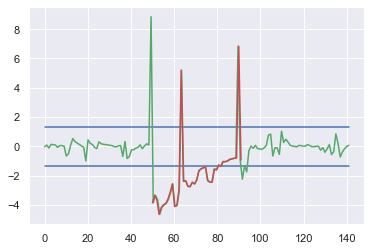

In [313]:
tmp = data['WEC: max. reactive Power']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = pipline(tmp1)

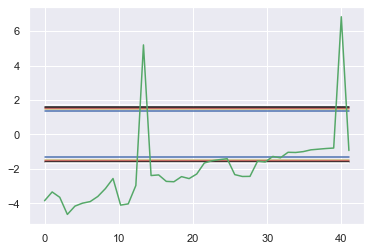

In [100]:
test_graph(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

In [291]:
tmp = data['WEC: ava. available P from wind']


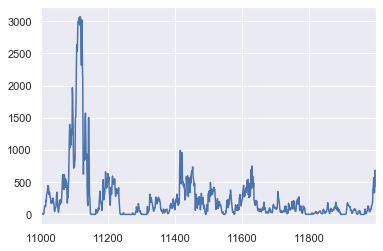

In [292]:
tmp[11000:12000].plot()

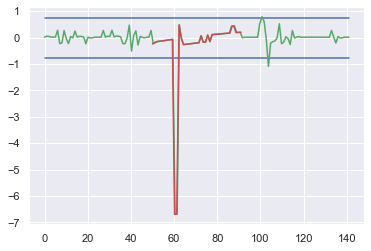

In [105]:
tmp = data['Sys 2 inverter 3 cabinet temp.']
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = pipline(tmp)

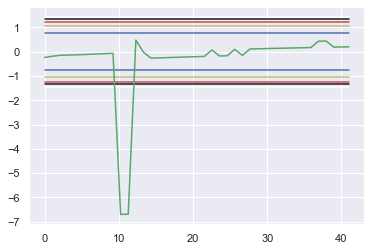

In [106]:
test_graph(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

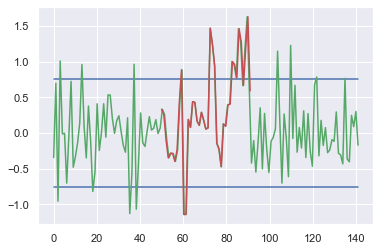

In [156]:
tmp = data['WEC: ava. available P from wind']
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = pipline(tmp)

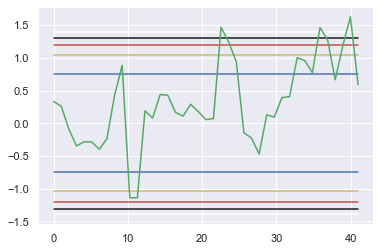

In [157]:
test_graph(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

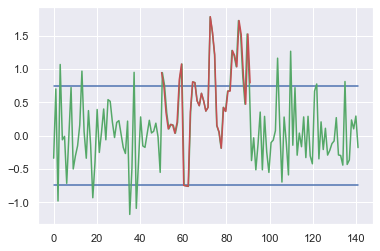

In [166]:
tmp = data['WEC: ava. Power']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = pipline(tmp1)

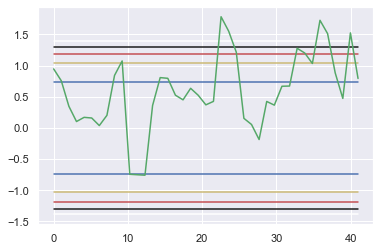

In [167]:
test_graph(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

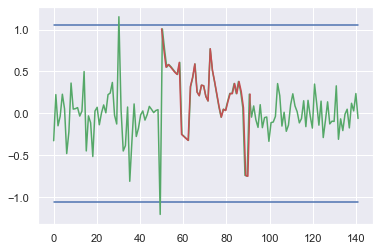

In [172]:
tmp = data['WEC: min. reactive Power']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = pipline(tmp1)

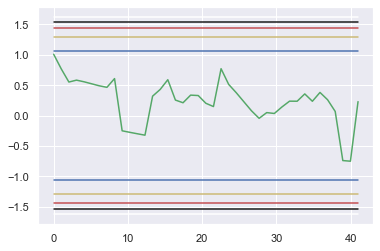

In [173]:
test_graph(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)


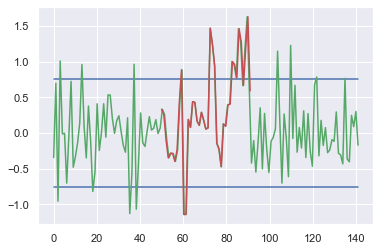

In [174]:
tmp = data['WEC: ava. available P from wind']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = pipline(tmp1)

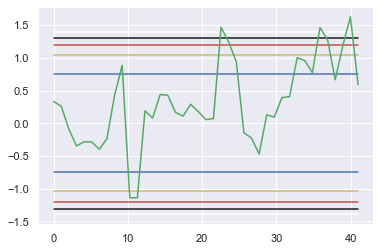

In [175]:
test_graph(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

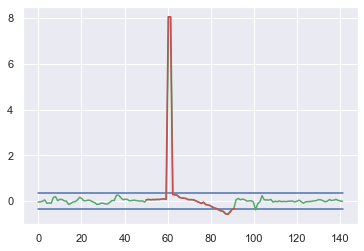

In [129]:
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = pipline(pc5)

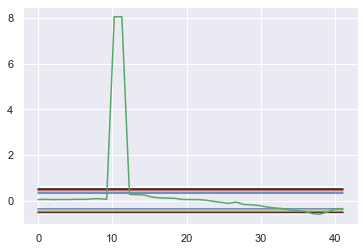

In [130]:
test_graph(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

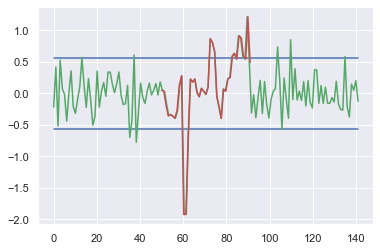

In [133]:
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = pipline(pc2)

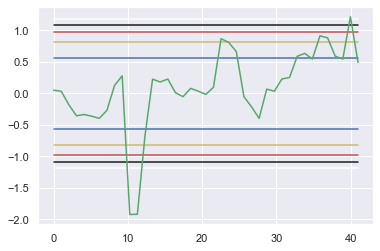

In [134]:
test_graph(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

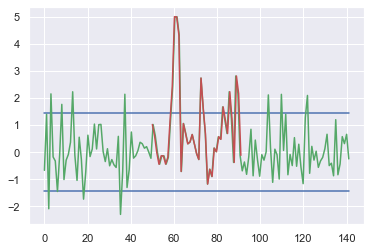

In [136]:
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = pipline(pc2)

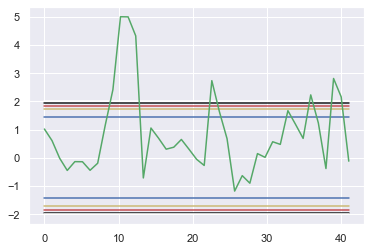

In [137]:
test_graph(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

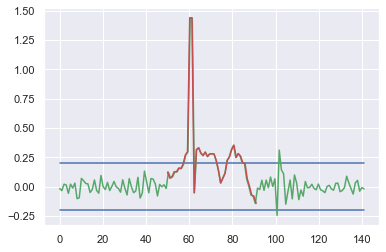

In [140]:
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = pipline(pc5)

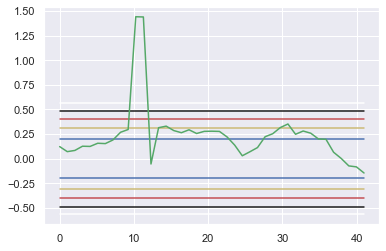

In [141]:
test_graph(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

In [142]:
pc5_14 = M5[:,13]

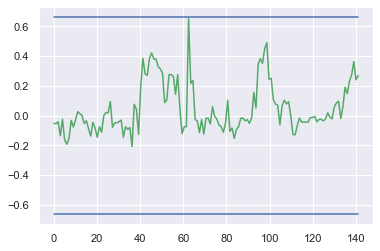

In [146]:
mean = np.mean(pc5_14)
std = np.std(pc5_14,ddof=1)
tmp = pc5_14[19905:20046]
up = []
down = []
for i in range(len(tmp)):
    up.append(mean+3*std)
    down.append(mean-3*std)
x2 = np.linspace(0,141,141)
plt.plot(x2,up,c='b')
plt.plot(x2,down,c='b')
plt.plot(x2,tmp,'g')

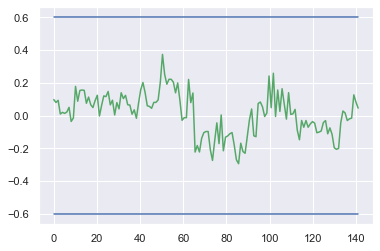

In [152]:
pc5_14 = M5[:,14]
mean = np.mean(pc5_14)
std = np.std(pc5_14,ddof=1)
tmp = pc5_14[19905:20046]
up = []
down = []
for i in range(len(tmp)):
    up.append(mean+3*std)
    down.append(mean-3*std)
x2 = np.linspace(0,141,141)
plt.plot(x2,up,c='b')
plt.plot(x2,down,c='b')
plt.plot(x2,tmp,'g')

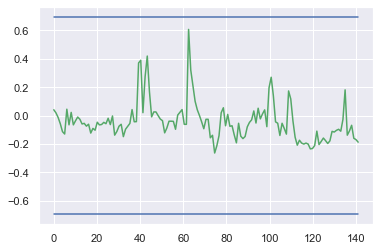

In [153]:
pc5_14 = M5[:,12]
mean = np.mean(pc5_14)
std = np.std(pc5_14,ddof=1)
tmp = pc5_14[19905:20046]
up = []
down = []
for i in range(len(tmp)):
    up.append(mean+3*std)
    down.append(mean-3*std)
x2 = np.linspace(0,141,141)
plt.plot(x2,up,c='b')
plt.plot(x2,down,c='b')
plt.plot(x2,tmp,'g')

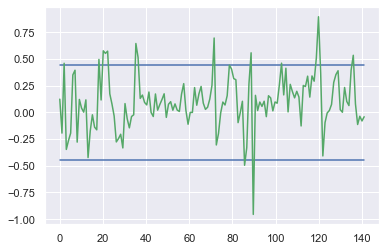

In [148]:
pc2_10 = M2[:,9]
mean2 = np.mean(pc2_10)
std2 = np.std(pc2_10,ddof=1)
tmp2 = pc2_10[19905:20046]
up2 = []
down2 = []
for i in range(len(tmp2)):
    up2.append(mean2+3*std2)
    down2.append(mean2-3*std2)
x2 = np.linspace(0,141,141)
plt.plot(x2,up2,c='b')
plt.plot(x2,down2,c='b')
plt.plot(x2,tmp2,'g')

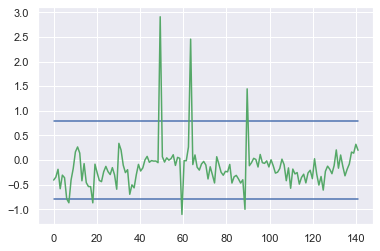

In [150]:
pc2_10 = M2[:,8]
mean2 = np.mean(pc2_10)
std2 = np.std(pc2_10,ddof=1)
tmp2 = pc2_10[19905:20046]
up2 = []
down2 = []
for i in range(len(tmp2)):
    up2.append(mean2+3*std2)
    down2.append(mean2-3*std2)
x2 = np.linspace(0,141,141)
plt.plot(x2,up2,c='b')
plt.plot(x2,down2,c='b')
plt.plot(x2,tmp2,'g')

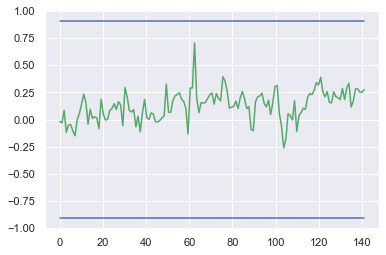

In [151]:
pc2_10 = M2[:,7]
mean2 = np.mean(pc2_10)
std2 = np.std(pc2_10,ddof=1)
tmp2 = pc2_10[19905:20046]
up2 = []
down2 = []
for i in range(len(tmp2)):
    up2.append(mean2+3*std2)
    down2.append(mean2-3*std2)
x2 = np.linspace(0,141,141)
plt.plot(x2,up2,c='b')
plt.plot(x2,down2,c='b')
plt.plot(x2,tmp2,'g')

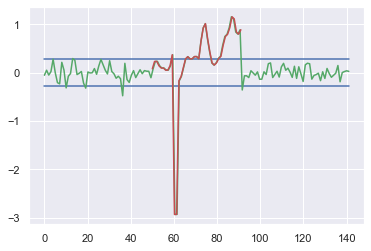

In [74]:
pipline(data,'Stator temp. 2')

In [33]:
data2 = data['WEC: max. windspeed']
train,test,var = split_data1(data2)
e1,m1,std1,params = one_step_ahead_train(train,var)
e2,m2,std2 = k_step_ahead_train(params,train,var,2)
e3,m3,std3 = k_step_ahead_train(params,train,var,3)
e4,m4,std4 = k_step_ahead_train(params,train,var,4)
e5,m5,std5 = k_step_ahead_train(params,train,var,5)

In [43]:
predictions = one_step_ahead_test(params,test,var)
result = multi_prediction(var,params)

In [44]:
for i in range(50,91):
    predictions[i] = result[i-50]

In [63]:
error = np.array(test) - np.array(predictions)

In [65]:
correct = np.array(test)
error1 = correct[50:91] - result

In [51]:
x1 = np.linspace(50,91,41)
x2 = np.linspace(0,141,141)

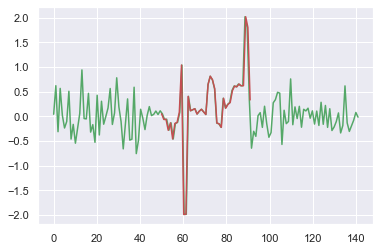

In [67]:
plt.plot(x2,error,'g')
plt.plot(x1,error1,'r')


In [262]:
M5,M2 = pca_process(datagroup_2,datagroup_5)

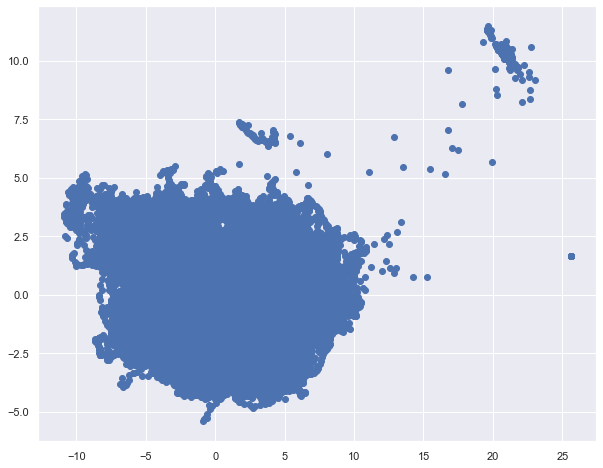

In [8]:
plt.figure(figsize=(10,8)) 
plt.scatter(M5[:,0], M5[:,1]) 

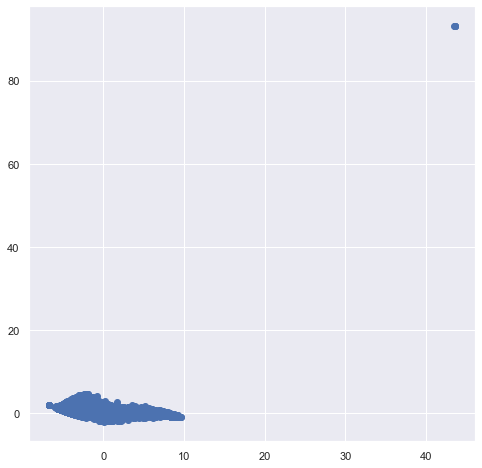

In [9]:
plt.figure(figsize=(8,8)) 
plt.scatter(M2[:,0], M2[:,1]) 

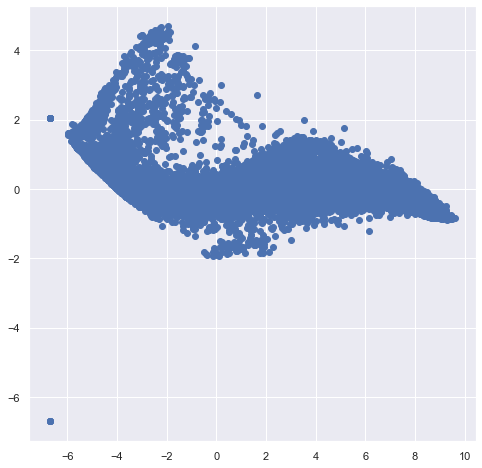

In [17]:
plt.figure(figsize=(8,8)) 
plt.scatter(M2[:,0], M2[:,1]) 

In [263]:
pc5 = []
for i in range(3000):
    pc5.append(0)
for i in range(46027):
    pc5.append(M5[i,0])

In [267]:
pc2 = []
for i in range(3000):
    pc2.append(0)
for i in range(46027):
    pc2.append(M2[i,0])

In [126]:
tmp1

array([2.96814311e-16, 2.96814311e-16, 2.96814311e-16, ...,
       1.93576930e+00, 2.07481197e+00, 2.21454602e+00])

In [230]:
g2 = datagroup_2.loc[3000:]
g5 = datagroup_5.loc[3000:]
scaler2 = StandardScaler()
scaler5 = StandardScaler()
g2_std = scaler2.fit_transform(g2) 
g5_std = scaler5.fit_transform(g5) 
pca5 = PCA(n_components=15)
pca5.fit(g5_std) 
components_M5 = pca5.transform(g5_std )
pca2 = PCA(n_components=10)
pca2.fit(g2_std ) 
components_M2 = pca2.transform(g2_std )

In [222]:
contri2 = pca5.components_[0,:]

In [223]:
contri2

array([-0.1711036 , -0.17226681, -0.17709071, -0.18615236, -0.17958715,
       -0.18683552, -0.19353489, -0.1961264 , -0.19393601, -0.19032891,
       -0.1892253 ,  0.06724281, -0.18332283, -0.19618607, -0.18784691,
       -0.18171163, -0.18268159, -0.18466132, -0.18483767, -0.18456828,
       -0.18927107, -0.18299405, -0.19811531, -0.15893832, -0.19698041,
       -0.19046351, -0.18077163, -0.14802059, -0.16099561, -0.11727028,
       -0.19627887])

In [225]:
Group_5[11]

'Sys 2 inverter 5 cabinet temp.'

In [228]:
Group_5[29]

'Transformer temp.'

In [206]:
sum = 0
for i in range(31):
    contri[i] = abs(contri[i])
    sum = sum + contri[i]
for i in range(31):
    contri[i] = contri[i]/sum

    

In [207]:
contri

array([0.03105697, 0.0312681 , 0.03214369, 0.03378846, 0.03259681,
       0.03391247, 0.03512847, 0.03559885, 0.03520127, 0.03454655,
       0.03434623, 0.01220522, 0.03327488, 0.03560968, 0.03409604,
       0.03298243, 0.03315849, 0.03351783, 0.03354984, 0.03350094,
       0.03435454, 0.0332152 , 0.03595986, 0.02884885, 0.03575386,
       0.03457098, 0.03281181, 0.02686718, 0.02922227, 0.0212857 ,
       0.03562653])

In [231]:
contri4 = pca2.components_[0,:]

In [232]:
contri4

array([0.24620559, 0.23563715, 0.23293592, 0.22919536, 0.25652895,
       0.24811495, 0.24478294, 0.23625541, 0.20005704, 0.22558321,
       0.22853087, 0.23079205, 0.22964177, 0.22865818, 0.23991821,
       0.23943373, 0.24260667, 0.24247836])

In [233]:
sum = 0
for i in range(18):
    contri4[i] = abs(contri4[i])
    sum = sum + contri4[i]
print(sum)
for i in range(18):
    contri4[i] = contri4[i]/sum


4.2373563595519705


In [213]:
contri4

array([0.05810358, 0.05560947, 0.05497199, 0.05408923, 0.06053986,
       0.05855419, 0.05776784, 0.05575538, 0.0472127 , 0.05323678,
       0.05393242, 0.05446605, 0.05419458, 0.05396246, 0.05661978,
       0.05650545, 0.05725425, 0.05722397])

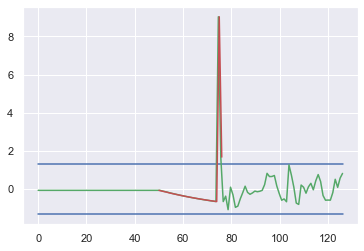

In [249]:
tmp = data['WEC: max. reactive Power']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp1)

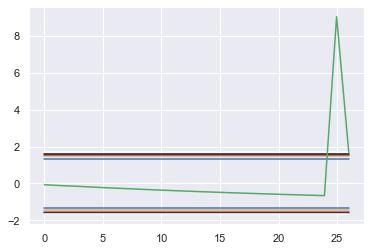

In [251]:
test_graphGF(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

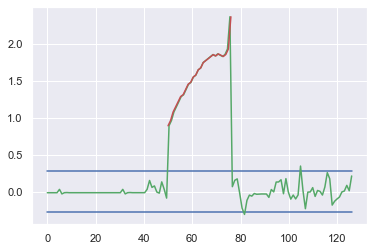

In [254]:
tmp = data['Stator temp. 2']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp1)

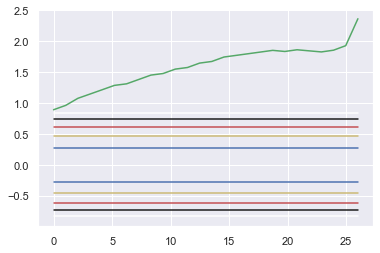

In [256]:
test_graphGF(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

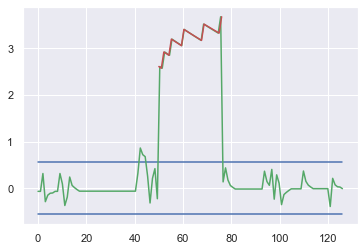

In [257]:
tmp = data['Rear bearing temp.']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp1)

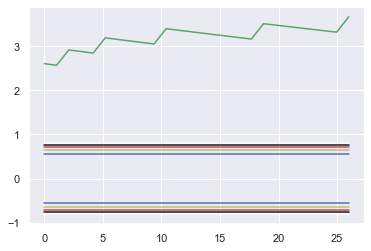

In [258]:
test_graphGF(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

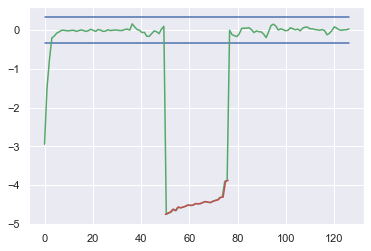

In [265]:
tmp = pc5
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp)

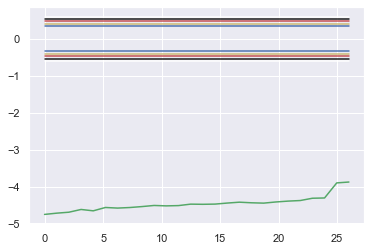

In [266]:
test_graphGF(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

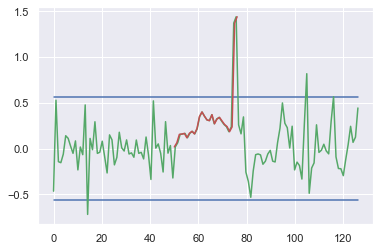

In [268]:
tmp = pc2
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp)

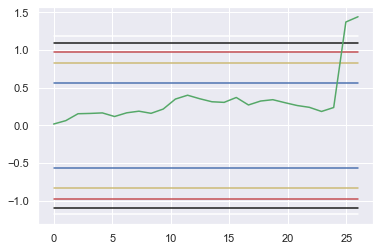

In [269]:
test_graphGF(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

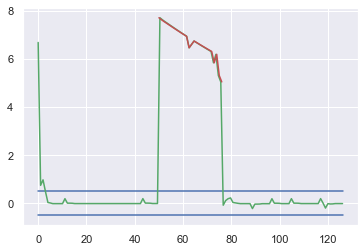

In [270]:
tmp = data['Sys 1 inverter 5 cabinet temp.']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp1)

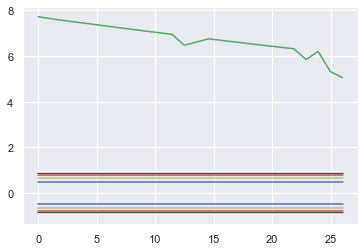

In [271]:
test_graphGF(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

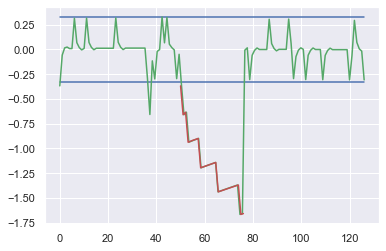

In [272]:
tmp = data['Nacelle cabinet temp.']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp1)

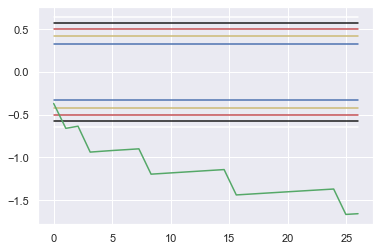

In [273]:
test_graphGF(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

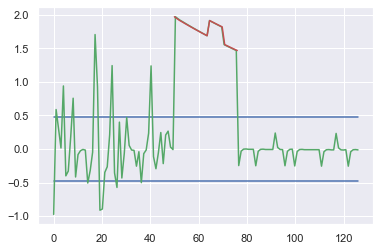

In [274]:
tmp = data['Pitch cabinet blade A temp.']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp1)

In [305]:
tmp = data['Inverter averages']

In [307]:
tmp[22905:23046]

22905    29.636364
22906    29.727272
22907    29.727272
22908    29.454546
22909    30.090910
           ...    
23041    28.545454
23042    28.272728
23043    28.363636
23044    28.363636
23045    28.454546
Name: Inverter averages, Length: 141, dtype: float64

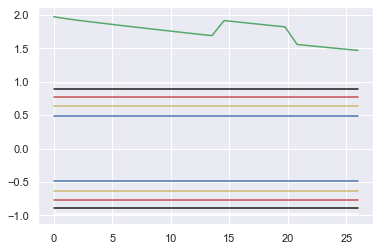

In [275]:
test_graphGF(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

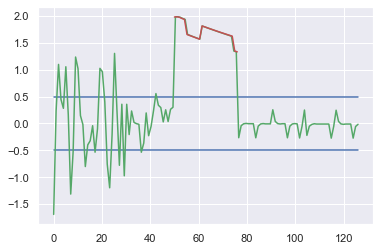

In [276]:
tmp = data['Pitch cabinet blade B temp.']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp1)

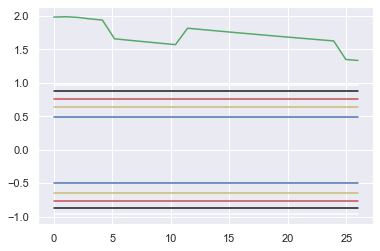

In [277]:
test_graphGF(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

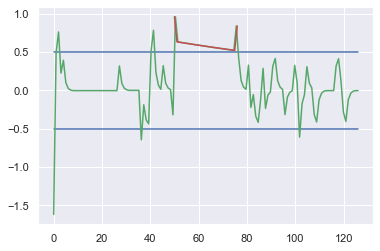

In [278]:
tmp = data['Yaw inverter cabinet temp.']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp1)

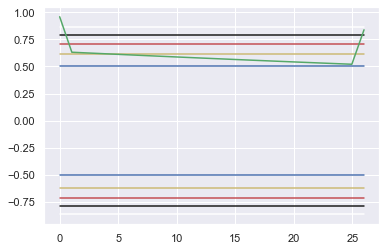

In [279]:
test_graphGF(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

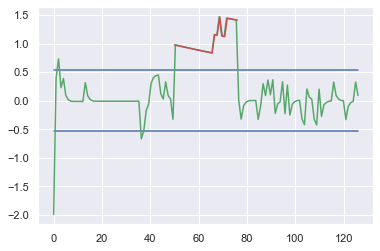

In [280]:
tmp = data['Fan inverter cabinet temp.']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp1)

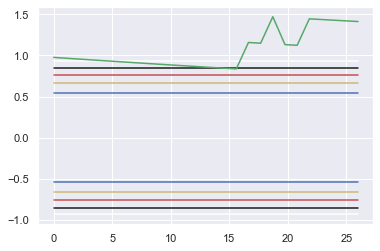

In [281]:
test_graphGF(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

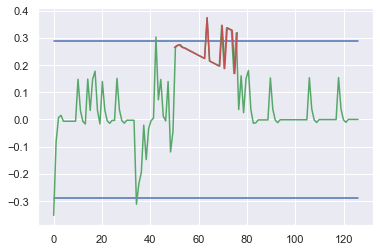

In [282]:
tmp = data['Control cabinet temp.']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp1)

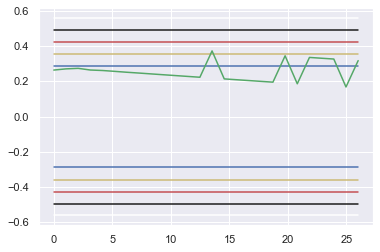

In [283]:
test_graphGF(m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1)

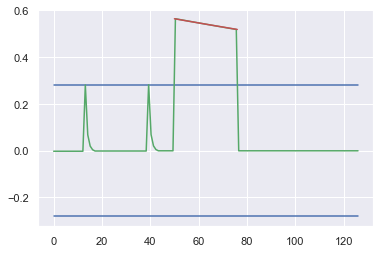

In [284]:
tmp = data['Main carrier temp.']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp1)

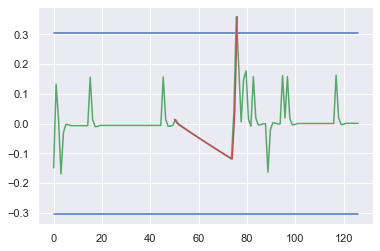

In [285]:
tmp = data['Tower temp.']
tmp1 = np.array(tmp)
m1,m2,m3,m4,m5,std1,std2,std3,std4,std5,errol1 = piplineGF(tmp1)